In [1]:
import sys
sys.path.append('../../../../../')

In [2]:
import os
import json
import requests

from web3 import Web3, HTTPProvider

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from utils.eth_blocks_utils import get_block_for_timestamp, get_timestamp_for_block

from pandas import Timestamp

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [4]:
api = "https://api.thegraph.com/subgraphs/name/convex-community/volume-mainnet"

In [5]:
end_block = web3.eth.get_block_number()
end_time = get_timestamp_for_block(end_block-2)
end_time

1652875935

In [6]:
start_time = int(Timestamp(2022, 5, 1).timestamp())
start_block = get_block_for_timestamp(start_time)
start_block

14688630

In [7]:
step = 1000
time_steps = list(range(start_time, end_time, step))
time_boxes = list(zip(time_steps, time_steps[1:]))
len(time_boxes)

1512

In [8]:
pool_addr = "0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7"

In [9]:
compiled_data = []
c = len(time_boxes)
for time_box in time_boxes:
    query = f"""
    {{
      swapEvents(
        where: {{
          pool: "{pool_addr.lower()}"
          timestamp_gte: {time_box[0]}
          timestamp_lt: {time_box[1]}
        }}
      ) {{
        timestamp
        block
        buyer
        tokenSold
        tokenBought
        amountSoldUSD
        amountBoughtUSD
      }}
    }}
    """
    r = requests.post(api, json={'query': query})
    queried_data = dict(r.json())['data']['swapEvents']
    parsed_data = []
    for _data in queried_data:

        parsed_data.append(
          {
            'timestamp': pd.Timestamp.fromtimestamp(int(_data['timestamp'])),
            'block': int(_data['block']),
            'token_sold': _data['tokenSold'],
            'token_bought': _data['tokenBought'],
            'amount_sold': float(_data['amountSoldUSD']),
            'amount_bought': float(_data['amountBoughtUSD']),
            'buyer': _data['buyer']
          }
        )

    compiled_data.extend(parsed_data)

df_compiled = pd.DataFrame(compiled_data).set_index('timestamp')
df_compiled

,block,token_sold,token_bought,amount_sold,amount_bought,buyer
timestamp,,,,,,
2022-05-01 02:10:53,14688681,0xdac17f958d2ee523a2206206994597c13d831ec7,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,374684.208519,374605.576106,0xfa9a30350048b2bf66865ee20363067c66f67e58
2022-05-01 02:26:52,14688742,0xdac17f958d2ee523a2206206994597c13d831ec7,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,5153.224492,5152.141162,0x81c46feca27b31f3adc2b91ee4be9717d1cd3dd7
2022-05-01 02:23:48,14688735,0xdac17f958d2ee523a2206206994597c13d831ec7,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,3435.075369,3434.353949,0x81c46feca27b31f3adc2b91ee4be9717d1cd3dd7
2022-05-01 02:40:26,14688804,0xdac17f958d2ee523a2206206994597c13d831ec7,0x6b175474e89094c44da98b954eedeac495271d0f,2237.861988,2237.444264,0x12e599006a5f19819cde6fabcebbd8586688c8ac
2022-05-01 06:25:58,14689826,0xdac17f958d2ee523a2206206994597c13d831ec7,0x6b175474e89094c44da98b954eedeac495271d0f,111844.579691,111823.697880,0x12e599006a5f19819cde6fabcebbd8586688c8ac
...,...,...,...,...,...,...
2022-05-18 13:33:28,14798600,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x6b175474e89094c44da98b954eedeac495271d0f,40000.000000,39996.801898,0x521d155cee171dad885eae47a97a8c489c3c70c9
2022-05-18 13:30:16,14798587,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x6b175474e89094c44da98b954eedeac495271d0f,242000.000000,241981.218102,0xda39e48523770197ef3cbb70c1bf1cccf9b4b1e7
2022-05-18 13:47:20,14798670,0x6b175474e89094c44da98b954eedeac495271d0f,0xdac17f958d2ee523a2206206994597c13d831ec7,227113.465044,227374.226746,0xeef86c2e49e11345f1a693675df9a38f7d880c8f


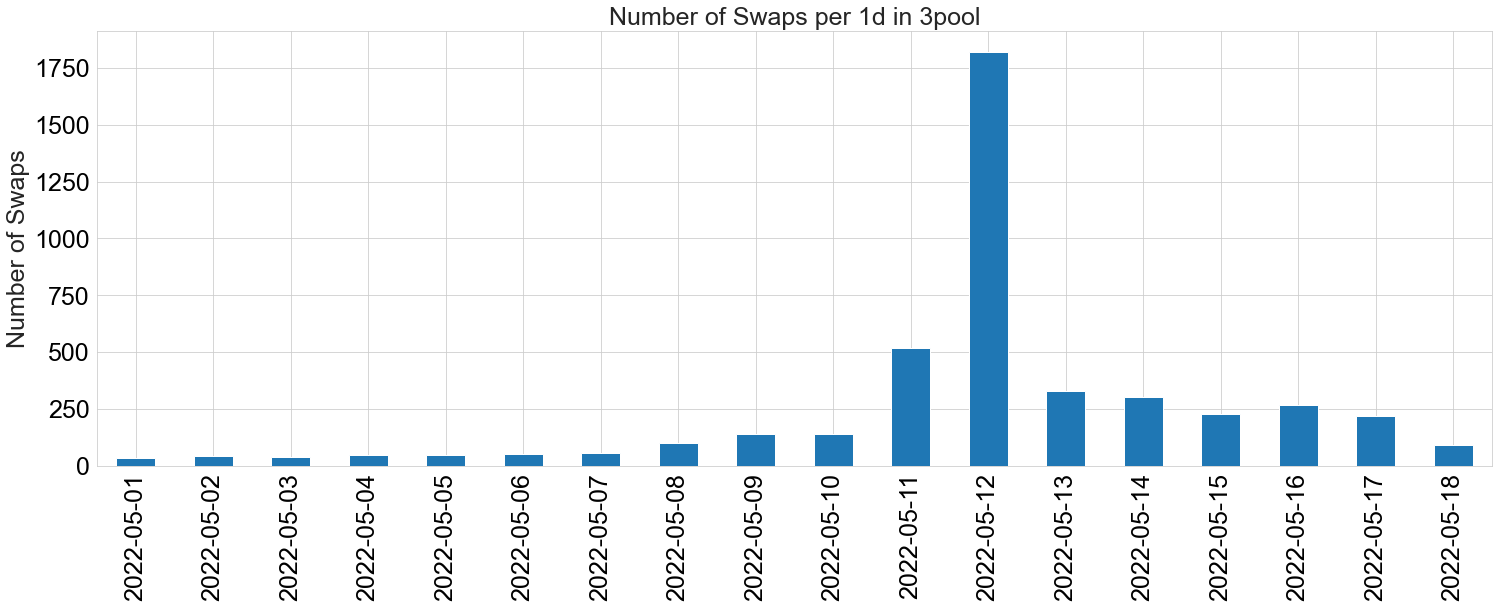

In [10]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))
freq = '1d'
df_grouped = df_compiled.amount_sold.groupby(pd.Grouper(freq=freq)).count()
df_grouped.index = df_grouped.index.date
df_grouped.plot(ax=ax, kind='bar')
ax.set_ylabel("Number of Swaps", fontsize=25)
ax.set_xlabel("", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')

ax.set_title(
    f"Number of Swaps per {freq} in 3pool",
    fontsize=25
);

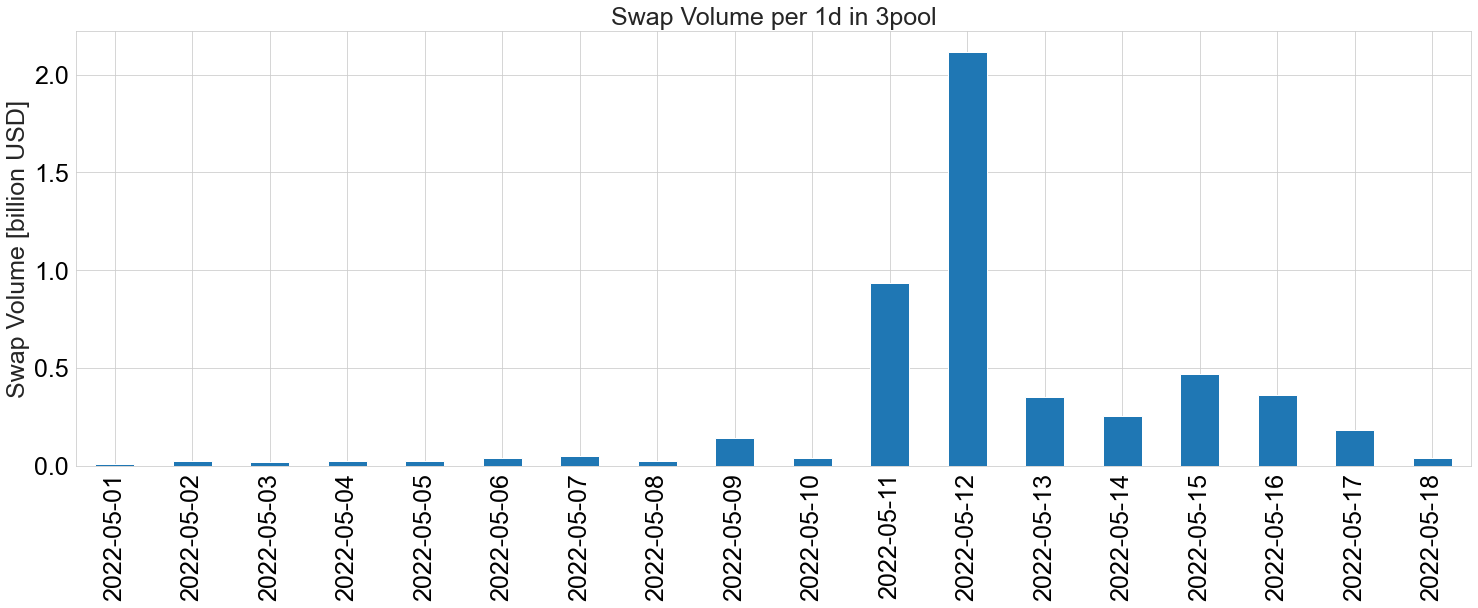

In [13]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))
freq = '1d'
df_grouped = df_compiled.amount_sold.groupby(pd.Grouper(freq=freq)).sum() * 1e-9
df_grouped.index = df_grouped.index.date
df_grouped.plot(ax=ax, kind='bar')
ax.set_ylabel("Swap Volume [billion USD]", fontsize=25)
ax.set_xlabel("", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')

ax.set_title(
    f"Swap Volume per {freq} in 3pool",
    fontsize=25
);